
# 📧 Email Marketing Performance Analysis (A/B Test + NLP)

**Goal:** Analyze email marketing campaign performance through A/B testing and natural language processing (NLP).  
**Dataset:** Synthetic dataset (`email_campaign_dataset.csv`, 1500 rows).  
**Environment:** Google Colab or Jupyter Notebook.


In [1]:

# Install dependencies if needed
# !pip install wordcloud scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import re
from collections import Counter

# Load dataset (ensure it's uploaded in /content if using Colab)
from google.colab import files
uploaded = files.upload()

#do it when content is seen
df = pd.read_csv('/content/email_campaign_dataset.csv')
df['send_date'] = pd.to_datetime(df['send_date'])
print("Rows:", len(df))
df.head()


Saving email_campaign_dataset.csv to email_campaign_dataset.csv
Rows: 1500


,row_id,campaign_id,send_date,recipient_id,variant,subject_line,body_preview,country,device,list_segment,send_hour,day_of_week,opened,clicked,clicks_count,bounce,unsubscribe,subject_sentiment_score,word_count_subject
0,1117,cmp_1464,2025-10-04 20:38:03,user_93160,B,Unlock your free shipping today,free shipping. Top picks in electronics. Shop ...,Germany,mobile,active_users,20,Saturday,1,0,0,0,0,3,5
1,1369,cmp_1770,2025-11-05 03:38:03,user_12850,A,Special offer on books,early access. Top picks in books. Shop now.,India,tablet,vip,3,Wednesday,1,0,0,0,0,1,4
2,423,cmp_1971,2025-11-02 00:38:03,user_46725,A,Don't miss out — free shipping for you,free shipping. Top picks in books. Shop now.,United States,tablet,vip,0,Sunday,0,0,0,0,0,0,8
3,414,cmp_1482,2025-08-25 06:38:03,user_12981,A,Don't miss out — exclusive discount for you,exclusive discount. Top picks in beauty. Shop ...,Germany,tablet,newsletter_only,6,Monday,0,0,0,0,0,2,8
4,452,cmp_1339,2025-10-03 02:38:03,user_21495,A,Don't miss out — buy 1 get 1 for you,buy 1 get 1. Top picks in electronics. Shop now.,France,tablet,newsletter_only,2,Friday,0,0,0,0,0,-1,10


In [2]:
print("Columns:", df.columns.tolist())
print(f"Overall open rate: {df['opened'].mean():.3f}")
print(f"Overall click rate: {df['clicked'].mean():.3f}")

summary = df.groupby('variant').agg(
    sends=('row_id','count'),
    open_rate=('opened','mean'),
    click_rate=('clicked','mean')
).reset_index()
summary


Columns: ['row_id', 'campaign_id', 'send_date', 'recipient_id', 'variant', 'subject_line', 'body_preview', 'country', 'device', 'list_segment', 'send_hour', 'day_of_week', 'opened', 'clicked', 'clicks_count', 'bounce', 'unsubscribe', 'subject_sentiment_score', 'word_count_subject']
Overall open rate: 0.185
Overall click rate: 0.025


,variant,sends,open_rate,click_rate
0,A,819,0.162393,0.020757
1,B,681,0.212922,0.030837


In [3]:

# A/B test: two-proportion z-test on open rates
counts = df.groupby('variant')['opened'].sum().values
nobs = df.groupby('variant')['opened'].count().values

stat, pval = proportions_ztest(count=counts, nobs=nobs)
print("Z-statistic:", stat, "P-value:", pval)
if pval < 0.05:
    print("✅ Significant difference between A and B (p < 0.05)")
else:
    print("❌ No significant difference detected.")


Z-statistic: -2.507517267290875 P-value: 0.012158264099393383
✅ Significant difference between A and B (p < 0.05)


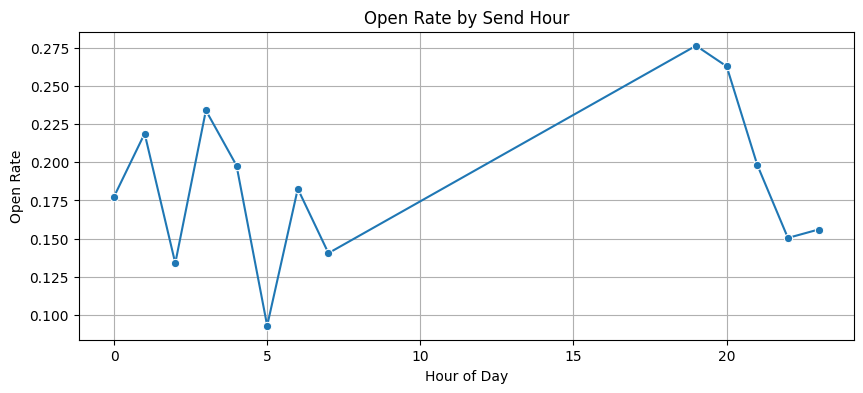

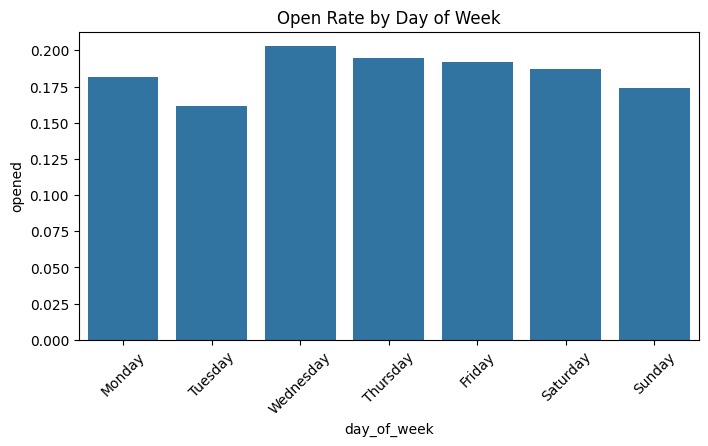

In [4]:

# Time-based analysis
hourly = df.groupby('send_hour')['opened'].mean().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(data=hourly, x='send_hour', y='opened', marker='o')
plt.title("Open Rate by Send Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Open Rate")
plt.grid(True)
plt.show()

dow = df.groupby('day_of_week')['opened'].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).reset_index()
plt.figure(figsize=(8,4))
sns.barplot(data=dow, x='day_of_week', y='opened')
plt.xticks(rotation=45)
plt.title("Open Rate by Day of Week")
plt.show()


In [5]:

# Segment & device analysis
print("Open rate by list segment:")
print(df.groupby('list_segment')['opened'].mean().sort_values(ascending=False))

print("\nOpen rate by device:")
print(df.groupby('device')['opened'].mean().sort_values(ascending=False))


Open rate by list segment:
list_segment
new_users          0.206522
churn_risk         0.204152
vip                0.195719
active_users       0.168919
newsletter_only    0.153846
Name: opened, dtype: float64

Open rate by device:
device
mobile     0.211765
tablet     0.186508
desktop    0.156379
Name: opened, dtype: float64


In [6]:

# NLP on subject lines
def tokenize(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return [t for t in text.split() if len(t) > 1]

df['subject_tokens'] = df['subject_line'].apply(tokenize)
all_tokens = [t for tokens in df['subject_tokens'] for t in tokens]
Counter(all_tokens).most_common(20)


[('you', 440),
 ('off', 436),
 ('for', 432),
 ('exclusive', 359),
 ('your', 316),
 ('inside', 308),
 ('today', 300),
 ('on', 285),
 ('free', 234),
 ('shipping', 234),
 ('buy', 234),
 ('get', 234),
 ('50', 223),
 ('discount', 221),
 ('early', 220),
 ('access', 220),
 ('20', 213),
 ('update', 175),
 ('limited', 168),
 ('time', 168)]

Correlation between subject sentiment score and opened: 0.054264468935096885


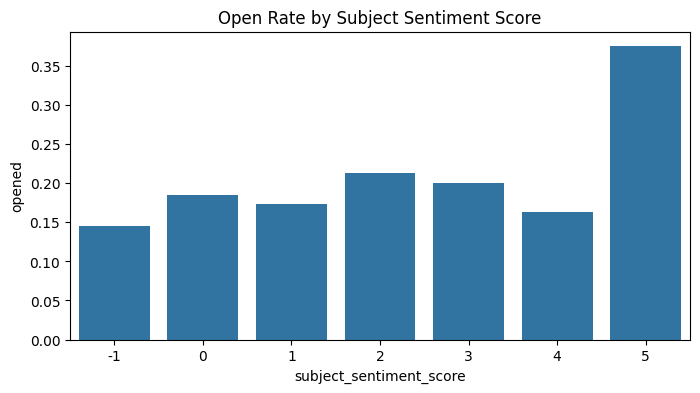

In [7]:

# Sentiment correlation with opens
corr = df['subject_sentiment_score'].corr(df['opened'])
print("Correlation between subject sentiment score and opened:", corr)

sent_bin = df.groupby('subject_sentiment_score')['opened'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(data=sent_bin, x='subject_sentiment_score', y='opened')
plt.title("Open Rate by Subject Sentiment Score")
plt.show()


In [8]:

# Predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = df[['variant','send_hour','device','list_segment','word_count_subject','subject_sentiment_score']].copy()
y = df['opened']
X = pd.get_dummies(X, columns=['variant','device','list_segment'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.81      1.00      0.90       244
           1       0.00      0.00      0.00        56

    accuracy                           0.81       300
   macro avg       0.41      0.50      0.45       300
weighted avg       0.66      0.81      0.73       300

ROC AUC: 0.5228337236533959


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:

# Top words by variant
def top_words_for(group_df, n=10):
    tokens = [t for tokens in group_df['subject_tokens'] for t in tokens]
    return Counter(tokens).most_common(n)

print("Top words for variant A (opened):", top_words_for(df[(df['variant']=='A') & (df['opened']==1)]))
print("\nTop words for variant B (opened):", top_words_for(df[(df['variant']=='B') & (df['opened']==1)]))


Top words for variant A (opened): [('off', 41), ('your', 34), ('update', 34), ('limited', 30), ('time', 30), ('inside', 30), ('50', 25), ('dont', 25), ('miss', 25), ('out', 25)]

Top words for variant B (opened): [('for', 54), ('you', 50), ('exclusive', 45), ('off', 40), ('unlock', 36), ('your', 36), ('today', 36), ('only', 33), ('few', 33), ('early', 31)]


In [10]:

# Export summary
report = df.groupby(['variant']).agg(
    sends=('row_id','count'),
    open_rate=('opened','mean'),
    click_rate=('clicked','mean')
).reset_index()
report.to_csv('/content/ab_report_summary.csv', index=False)
print("Saved A/B summary to /content/ab_report_summary.csv")


Saved A/B summary to /content/ab_report_summary.csv
